### 라이브러리 불러오기

In [2]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time


device = torch.device('cuda:1')

In [2]:
train_png = sorted(glob('data/rawdata/train/*.png'))
test_png = sorted(glob('data/rawdata/test/*.png'))

In [ ]:
path = 'data/rawdata/test/20000.png'

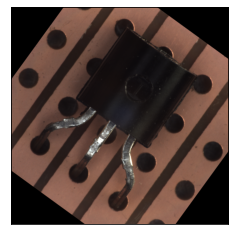

In [6]:
img = cv2.imread('data/rawdata/test/20002.png')[:,:,::-1]
cv2.imshow('img',img)

from matplotlib import pyplot as plt # as는 alias 적용시 사용



plt.imshow(img)
plt.xticks([]) # x축 눈금
plt.yticks([]) # y축 눈금
plt.show()

In [8]:
type(img)

numpy.ndarray

In [4]:
train_y = pd.read_csv("train_df.csv")

train_labels = train_y["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

In [5]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (512, 512))
    return img

In [6]:
train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(n) for n in tqdm(test_png)]

100%|██████████| 2154/2154 [02:41<00:00, 13.36it/s]


In [7]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy()
            elif augmentation==2:
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [8]:
batch_size = 32
epochs = 2

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

### 모델 학습

In [9]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 



best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to C:\Users\82109/.cache\torch\hub\checkpoints\efficientnet_b0_ra-3dd342df.pth


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 805306368 bytes.

### 추론

In [15]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [16]:
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

### 제출물 생성

In [17]:
submission = pd.read_csv("open/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-misplaced
3,3,tile-crack
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [21]:
submission.to_csv("baseline.csv", index = False)